In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Input, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from dmba import plotDecisionTree  # Graphiz is required for this function
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from dmba import classificationSummary
import lightgbm as lgb

In [8]:
df = pd.read_csv('spam_ham_dataset.csv')
df.head()

Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0

In [9]:
df.describe()

Unnamed: 0    label_num
count  5171.000000  5171.000000
mean   2585.000000     0.289886
std    1492.883452     0.453753
min       0.000000     0.000000
25%    1292.500000     0.000000
50%    2585.000000     0.000000
75%    3877.500000     1.000000
max    5170.000000     1.000000

Total messages: 5171
Number of Spam messages: 1499
Number of Ham messages: 3672


<Axes: xlabel='label', ylabel='count'>

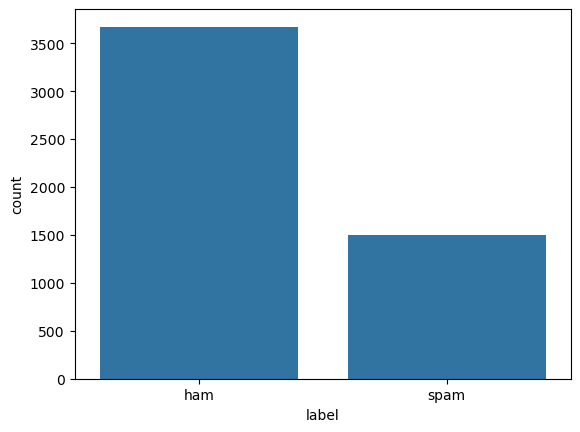

In [10]:
# Spam and Ham distribution
print("Total messages:", len(df))
print("Number of Spam messages:", len(df[df['label'] == 'spam']))
print("Number of Ham messages:", len(df[df['label'] == 'ham']))
sns.countplot(x='label', data=df)

### Data Preprocessing and Cleansing

In [11]:
# nltk.download('stopwords')
stop_words_list = stopwords.words('english')
stop_words_list[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [12]:
def clean_text_with_tokenize(text):
    # 1. 불필요한 특수문자 제거
    text = re.sub(r"[^a-zA-Z']", ' ', text)

    # 2. 토큰화
    tokens = word_tokenize(text)

    # 3. 소문자 변환 (대소문자 구분 제거)
    tokens = [token.lower() for token in tokens]

    # 4. 길이 기반 필터링 (길이 3 이하인 토큰 제거; 노이즈 감소)
    tokens = [token for token in tokens if len(token) > 3]

    # 5. 불용어 제거
    tokens = [token for token in tokens if token not in stop_words_list]

    return tokens

# 1차 전처리
df['cleaned_text'] = df['text'].apply(clean_text_with_tokenize)
df['cleaned_text'].head()

0    [subject, enron, methanol, meter, follow, note...
1    [subject, january, attached, file, hplnol, hpl...
2    [subject, neon, retreat, around, wonderful, ti...
3    [subject, photoshop, windows, office, cheap, m...
4    [subject, indian, springs, deal, book, teco, r...
Name: cleaned_text, dtype: object

In [13]:
# 2차 전처리: 어간 추출 및 표제어 추출

# 어간, 표제어 추출 객체 생성
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# 어간 추출
df['cleaned_text'] = df['cleaned_text'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
print("Stemmed tokens:", df['cleaned_text'].head())

Stemmed tokens: 0    [subject, enron, methanol, meter, follow, note...
1     [subject, januari, attach, file, hplnol, hplnol]
2    [subject, neon, retreat, around, wonder, time,...
3    [subject, photoshop, window, offic, cheap, mai...
4    [subject, indian, spring, deal, book, teco, re...
Name: cleaned_text, dtype: object


In [14]:
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger_eng')

# 표제어 추출 수행 (품사 태깅)
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# 표제어 추출
# lemmatized_words = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag)) for token, tag in nltk.pos_tag(word_tokenize(df_token))]

df['cleaned_text'] = df['cleaned_text'].apply(lambda text: [
    lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
    for word, tag in pos_tag(text)
])
print("Lemmatized words:", df['cleaned_text'].head())

Lemmatized words: 0    [subject, enron, methanol, meter, follow, note...
1     [subject, januari, attach, file, hplnol, hplnol]
2    [subject, neon, retreat, around, wonder, time,...
3    [subject, photoshop, window, offic, cheap, mai...
4    [subject, indian, spring, deal, book, teco, re...
Name: cleaned_text, dtype: object


In [15]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join(x))

In [23]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})  # Ensure labels are numeric for training

In [24]:
vocab_size = 2500
max_length = 500

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print("원본 시퀀스:", sequences)
print("패딩된 시퀀스:", padded_sequences)
print("패딩된 시퀀스 형태:", padded_sequences.shape)

원본 시퀀스: [[2, 3, 640, 5, 34, 143, 91, 251, 1234, 35, 280, 69, 9, 58, 1, 73, 13, 414, 326, 403, 73, 112, 1105, 243, 18, 8, 993, 1302, 700], [2, 138, 21, 43, 1340, 1340], [2, 960, 1, 503, 1303, 23, 105, 960, 941, 1, 23, 14, 23, 105, 1630, 1, 1, 82, 381, 288, 1045, 557, 288, 102, 239, 138, 57, 82, 739, 1, 1258, 226, 1304, 1, 1, 70, 519, 138, 2430, 1, 1305, 1780, 1, 579, 102, 144, 18, 117, 34, 519, 138, 129, 305, 8, 82, 82, 308, 367, 671, 23, 1, 1781, 768, 1, 1710, 2237, 781, 249, 1487, 1780, 129, 641, 1173, 671, 519, 14, 1046, 99, 317, 27, 1, 1066, 311, 288, 453, 105, 105, 78, 1, 566, 1306, 1, 1515, 171, 1, 1, 994, 642, 642, 566, 491, 1572, 54, 358, 1, 183, 739, 1158, 685, 1, 1, 850, 1, 2366, 671, 512, 973, 23, 120, 803, 449, 900, 450, 57, 311, 288, 513, 317, 27, 721, 124, 2366, 671, 1515, 1, 1, 23, 267, 1, 203, 803, 269, 454, 2431, 92, 27, 306, 23, 671, 651, 39, 67, 27, 1046, 995, 72, 519, 1, 118, 1, 603, 2169, 1014, 575, 361, 257, 1046, 519, 2169, 1, 404, 57, 1, 196, 519, 196, 1158, 196,

### Lengths Histogram

In [ ]:
lengths = [len(x) for x in df['cleaned_text']]
print("Lengths of cleaned text:", max(lengths), min(lengths), np.mean(lengths))

Lengths of cleaned text: 19169 7 514.6888416167086


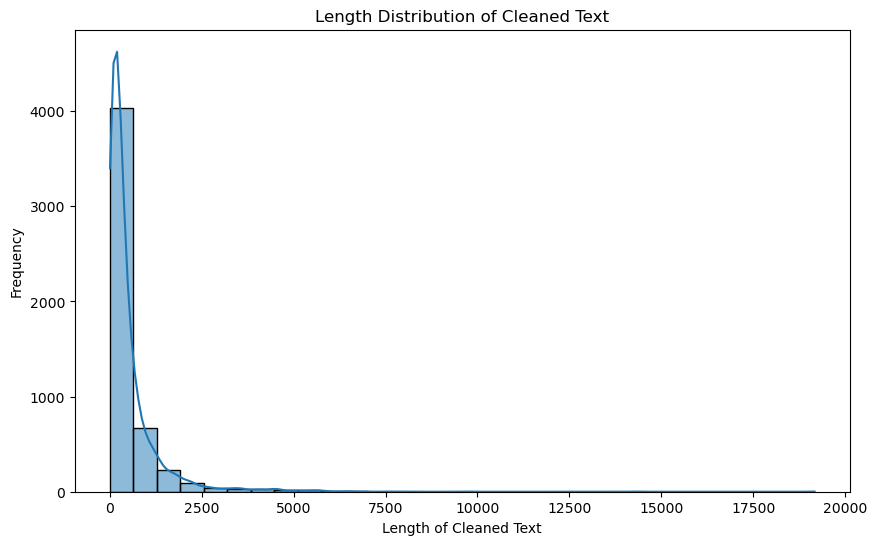

In [ ]:
# 길이 분포 시각화

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Length Distribution of Cleaned Text')
plt.xlabel('Length of Cleaned Text')
plt.ylabel('Frequency')
plt.show()

In [ ]:
all_text = df['cleaned_text'].str.cat(sep=' ')
words = all_text.split()
unique_words = set(words)
num_unique_words = len(unique_words)
print(f"데이터셋의 고유 단어 수: {num_unique_words}")

데이터셋의 고유 단어 수: 34981


### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, # 상위 1,000개의 단어를 보존 
max_df = 0.5, smooth_idf=True)

X = vectorizer.fit_transform(df['cleaned_text'])

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X.shape)

TF-IDF 행렬의 크기 : (5171, 1000)


In [ ]:
# TF-IDF 행렬 출력
print(X.toarray())

# 어휘 사전 출력
print("Vocabulary:", vectorizer.vocabulary_)

[[0.         0.         0.         ... 0.         0.23749504 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Vocabulary: {'enron': 285, 'methanol': 555, 'meter': 554, 'follow': 344, 'note': 598, 'monday': 569, 'flow': 343, 'data': 217, 'provid': 707, 'daren': 215, 'pleas': 668, 'daili': 213, 'volum': 966, 'present': 684, 'zero': 998, 'reflect': 738, 'activ': 8, 'control': 189, 'chang': 132, 'need': 585, 'asap': 58, 'purpos': 712, 'januari': 462, 'attach': 66, 'file': 335, 'neon': 587, 'time': 916, 'year': 995, 'leader': 492, 'know': 481, 'think': 911, 'anyth': 46, 'past': 639, 'holiday': 407, 'life': 500, 'week': 974, 'decemb': 226, 'like': 502, 'minut': 56

### LSTM + 1D CNN Classification

In [15]:
vocab_size = 2500
embedding_dim = 50  # 단어 임베딩 차원; 50~300 사이의 값이 일반적
max_length = 500  # 문장 최대 길이; 문장 길이를 맞추기 위해 패딩을 추가할 길이; 500-1000 시도 중
lstm_units = 256 # LSTM 유닛 수; 64~512 사이의 값이 일반적
dropout_rate = 0.2 # 드롭아웃 비율; 0.2~0.5 사이의 값이 일반적
spatial_dropout_rate = 0.2 # 공간적 드롭아웃 비율; 0.2~0.5 사이의 값이 일반적
cnn_filters = 128
kernel_size = 4
l2_reg = 0.001  # L2 규제 강도
pool_size = 2

In [ ]:
model_lstm_cnn = Sequential([
    Input(shape=(max_length,)),  # 입력 크기
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),  # 임베딩 층
    SpatialDropout1D(spatial_dropout_rate),  # 공간적 드롭아웃
    Conv1D(filters=cnn_filters, kernel_size=kernel_size, padding='same', activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),  # Normalization
    MaxPooling1D(pool_size=pool_size),  # 최대 풀링 층
    LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=False),  # LSTM 층
    Dense(units=1, activation='sigmoid')  # 이진 분류
])

# Adam 옵티마이저 설정
optimizer = Adam(learning_rate=0.0005)
model_lstm_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_lstm_cnn.summary()

c:\Users\Inkyu Yang\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 50)        │       125,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 500, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,737 (2.08 MB)

 Trainable params: 545,481 (2.08 MB)

 Non-trainable params: 256 (1.00 KB)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [22]:
# Callbacks 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습
history = model_lstm_cnn.fit(X_train, y_train, 
                            epochs=20,
                            batch_size=32,
                            validation_split=0.25, 
                            # class_weight={0:1, 1:3},  # spam(1) 클래스에 3배 가중치
                            callbacks=[early_stopping, reduce_lr],
                            verbose=1)

Epoch 1/20


97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 447ms/step - accuracy: 0.6695 - loss: 0.6328 - val_accuracy: 0.7311 - val_loss: 0.6409 - learning_rate: 5.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - accuracy: 0.7144 - loss: 0.6053 - val_accuracy: 0.7292 - val_loss: 0.6428 - learning_rate: 5.0000e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.7257 - loss: 0.5901 - val_accuracy: 0.7408 - val_loss: 0.6304 - learning_rate: 5.0000e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 391ms/step - accuracy: 0.7073 - loss: 0.6045 - val_accuracy: 0.7398 - val_loss: 0.6081 - learning_rate: 5.0000e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - accuracy: 0.7086 - loss: 0.6008 - val_accuracy: 0.7408 - val_loss: 0.5952 - learning_rate: 5.0000e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.7117 - loss: 0.5982 - val_accuracy: 0.7418 - val_loss: 0.5920 - learning_rate: 5.0000e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step - accuracy: 0.71

In [23]:
# 모델 평가
loss, accuracy = model_lstm_cnn.evaluate(X_test, y_test)
print(f'테스트 정확도: {accuracy}')
print(f'테스트 손실: {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8416 - loss: 0.4580
테스트 정확도: 0.833816409111023
테스트 손실: 0.4722001254558563


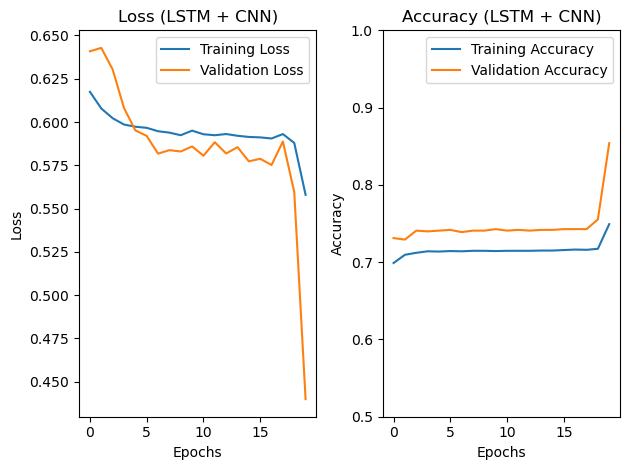

In [24]:
# 손실 및 정확도 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (LSTM + CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (LSTM + CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.legend()
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


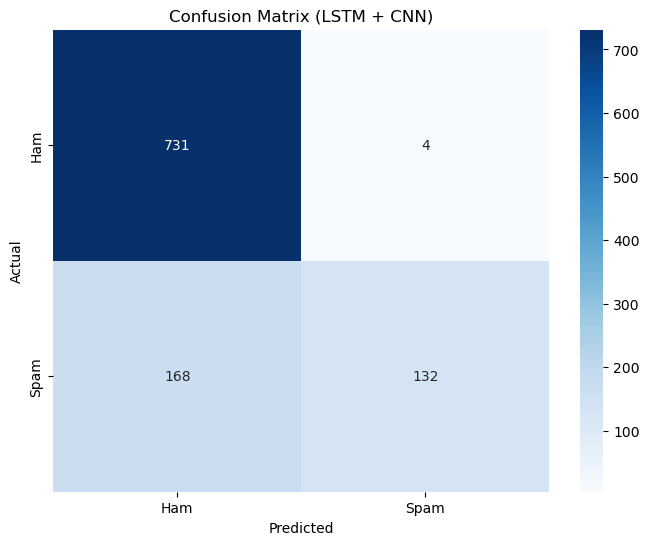

              precision    recall  f1-score   support

         Ham       0.81      0.99      0.89       735
        Spam       0.97      0.44      0.61       300

    accuracy                           0.83      1035
   macro avg       0.89      0.72      0.75      1035
weighted avg       0.86      0.83      0.81      1035



In [25]:
# 혼동 행렬
y_pred = (model_lstm_cnn.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix (LSTM + CNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# 분류 보고서
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

In [26]:
# 모델 저장
model_lstm_cnn.save('spam_ham_lstm_cnn_model.h5')

### SVD (Singular Value Decomposition)
### SVM (Support Vector Machine)

In [40]:
# SVD를 통한 차원 축소 (노이즈 제거, 계산 효율성 증가)
svd = TruncatedSVD(n_components=500, random_state=42)  # 500차원으로 축소
X_svd = svd.fit_transform(X)
print("SVD transformed shape:", X_svd.shape)

SVD transformed shape: (5171, 500)


In [41]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score

# SVM 모델 생성
svm_model = LinearSVC()

# Vectorizer Split
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size = 0.2, random_state = 42)

# 모델 학습
svm_model.fit(X_train, y_train)

# 예측
y_pred = svm_model.predict(X_test)

# 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9739130434782609

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       742
           1       0.95      0.96      0.95       293

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



In [42]:
svm = SVC(kernel = 'linear', random_state = 42)
svm.fit(X_train,y_train)

svm_pred = svm.predict(X_test)

print(accuracy_score(y_test,svm_pred))

# SVC는 작은 데이터셋에 적합하며, 확률 점수 제공 함수가 존재합니다.
# 속도는 상대적으로 느리며 메모리 사용량이 높습니다.

# 반면, LinearSVC()는 대규모 데이터셋에 적합하며, 확률 점수 제공 함수가 존재하지 않습니다.
# 속도는 빠르며, 메모리 사용량이 적습니다.

0.9710144927536232


In [43]:
clist = [50, 100, 200, 300, 400, 500]
for i in clist:
    print(f"n_components = {i}")
    svd = TruncatedSVD(n_components=i, random_state=42)
    X_svd = svd.fit_transform(X)
    print("SVD transformed shape:", X_svd.shape)

    # SVM 모델 생성
    svm_model = LinearSVC()

    # Vectorizer Split
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size = 0.2, random_state = 42)

    # 모델 학습
    svm_model.fit(X_train, y_train)

    # 예측
    y_pred = svm_model.predict(X_test)

    # 평가
    print("Accuracy:", accuracy_score(y_test, y_pred), "\n")

n_components = 50
SVD transformed shape: (5171, 50)
Accuracy: 0.9603864734299516 

n_components = 100
SVD transformed shape: (5171, 100)
Accuracy: 0.966183574879227 

n_components = 200
SVD transformed shape: (5171, 200)
Accuracy: 0.9710144927536232 

n_components = 300
SVD transformed shape: (5171, 300)
Accuracy: 0.970048309178744 

n_components = 400
SVD transformed shape: (5171, 400)
Accuracy: 0.9739130434782609 

n_components = 500
SVD transformed shape: (5171, 500)
Accuracy: 0.9739130434782609 



<Axes: >

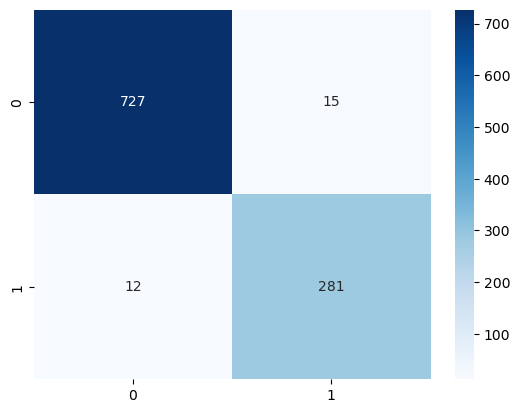

In [44]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, cmap = 'Blues',fmt = '1.0f')

### Bi-LSTM

In [25]:
# 하이퍼파라미터 설정
vocab_size = 2500
embedding_dim = 50
max_length = 500
lstm_units = 128
dropout_rate = 0.5
l2_reg = 0.01  # L2 규제 강도

# 모델 정의
model_bilstm = Sequential([
    Input(shape=(max_length,)),  # 입력 크기
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),  # 임베딩 층
    SpatialDropout1D(dropout_rate),  # 공간적 드롭아웃
    Bidirectional(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, kernel_regularizer=l2(l2_reg))),  # Bidirectional LSTM (L2 규제)
    Dense(units=1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # 출력층 (이진 분류, L2 규제))
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
model_bilstm.compile(optimizer=optimizer, 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

# 모델 요약
model_bilstm.summary()

c:\Users\Inkyu Yang\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 50)        │       125,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 500, 50)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,553 (1.18 MB)

 Trainable params: 308,553 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# 데이터셋 분리
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42, stratify=df['label'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# 검증 손실을 모니터링, 학습률을 50%로 감소, 3번 연속 개선되지 않으면 학습률 감소, 학습률의 하한선, 메시지 출력

In [27]:
# 모델 학습
history = model_bilstm.fit(X_train, y_train, 
                         epochs=20, batch_size=32, 
                         validation_split=0.25, verbose=1, 
                         callbacks=[early_stopping, reduce_lr])

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 476ms/step - accuracy: 0.7101 - loss: 1.9774 - val_accuracy: 0.8801 - val_loss: 0.8103 - learning_rate: 5.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - accuracy: 0.8456 - loss: 0.7289 - val_accuracy: 0.9342 - val_loss: 0.3361 - learning_rate: 5.0000e-04
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.9116 - loss: 0.3688 - val_accuracy: 0.9381 - val_loss: 0.2545 - learning_rate: 5.0000e-04
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 442ms/step - accuracy: 0.9306 - loss: 0.2802 - val_accuracy: 0.9545 - val_loss: 0.1982 - learning_rate: 5.0000e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 432ms/step - accuracy: 0.9550 - loss: 0.2326 - val_accuracy: 0.9526 - val_loss: 0.2031 - learning_rate: 5.0000e-04
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 437ms/step - accuracy: 0.9547 - loss: 0.2087 - val_accuracy: 0.9594 - val_loss: 0.1718 - learning_rate: 5.0000e-04
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - acc

In [28]:
# 모델 평가
loss, accuracy = model_bilstm.evaluate(X_test, y_test)
print(f'테스트 정확도: {accuracy}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9766 - loss: 0.1222
테스트 정확도: 0.9777777791023254


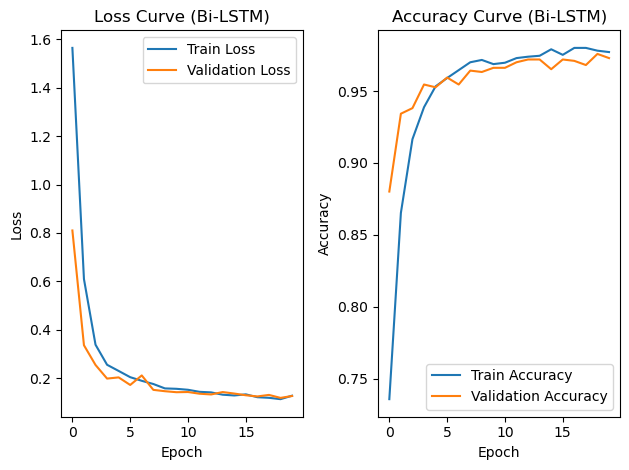

In [29]:
# 손실 곡선과 정확도 곡선을 시각화하여 모델의 학습 과정을 확인합니다.
plt.subplot(1, 2, 1)
plt.plot(model_bilstm.history.history['loss'], label='Train Loss')
plt.plot(model_bilstm.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (Bi-LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(model_bilstm.history.history['accuracy'], label='Train Accuracy')
plt.plot(model_bilstm.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (Bi-LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


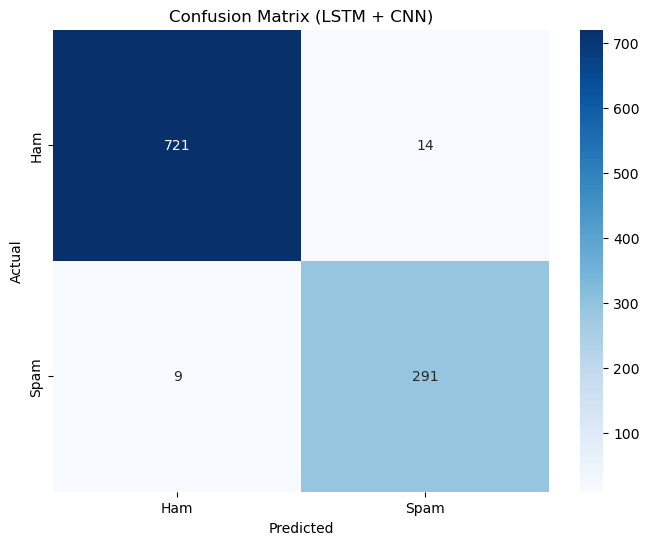

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       735
        Spam       0.95      0.97      0.96       300

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035



In [30]:
# 혼동 행렬
y_pred = (model_bilstm.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix (LSTM + CNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# 분류 보고서
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

In [33]:
# 모델 저장
model_bilstm.save('spam_ham_bilstm_model.h5')

### Decision Tree, Gradient Boosting

In [50]:
# Decision Tree 모델 생성
dt_model = DecisionTreeClassifier(max_depth=10, min_impurity_decrease=0.01, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['label'], test_size=0.2, random_state=42)

# 모델 학습
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.9130434782608695

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       742
           1       0.83      0.88      0.85       293

    accuracy                           0.91      1035
   macro avg       0.89      0.90      0.89      1035
weighted avg       0.92      0.91      0.91      1035



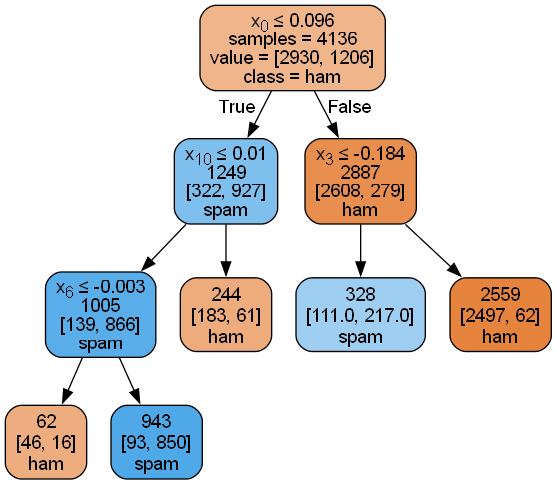

<Figure size 1200x800 with 0 Axes>

In [51]:
# 결정트리 시각화
plt.figure(figsize=(12, 8))
plotDecisionTree(dt_model, class_names=['ham', 'spam'])

In [52]:
# Random Forest 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# 모델 학습
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 평가
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Accuracy: 0.9565217391304348

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       742
           1       0.92      0.92      0.92       293

    accuracy                           0.96      1035
   macro avg       0.95      0.95      0.95      1035
weighted avg       0.96      0.96      0.96      1035



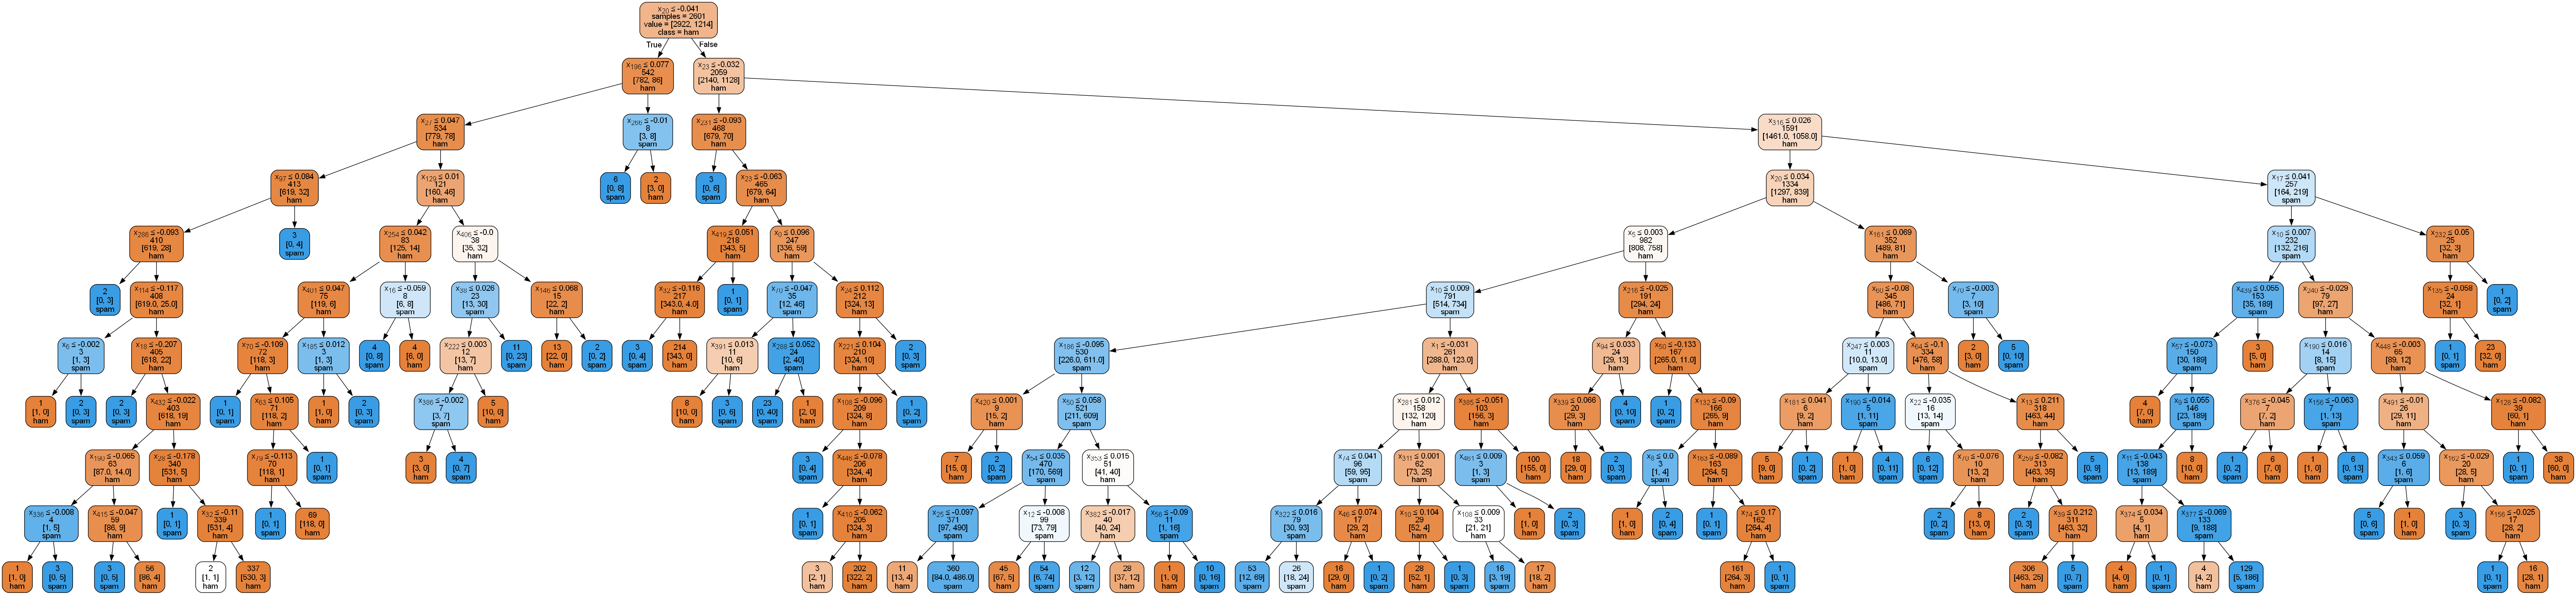

<Figure size 1200x800 with 0 Axes>

In [53]:
# 랜덤포레스트의 첫 번째 트리 시각화
plt.figure(figsize=(12, 8))
plotDecisionTree(rf_model.estimators_[0], class_names=['ham', 'spam'])

가장 좋은 트리 index: 43, 정확도: 0.9140096618357488


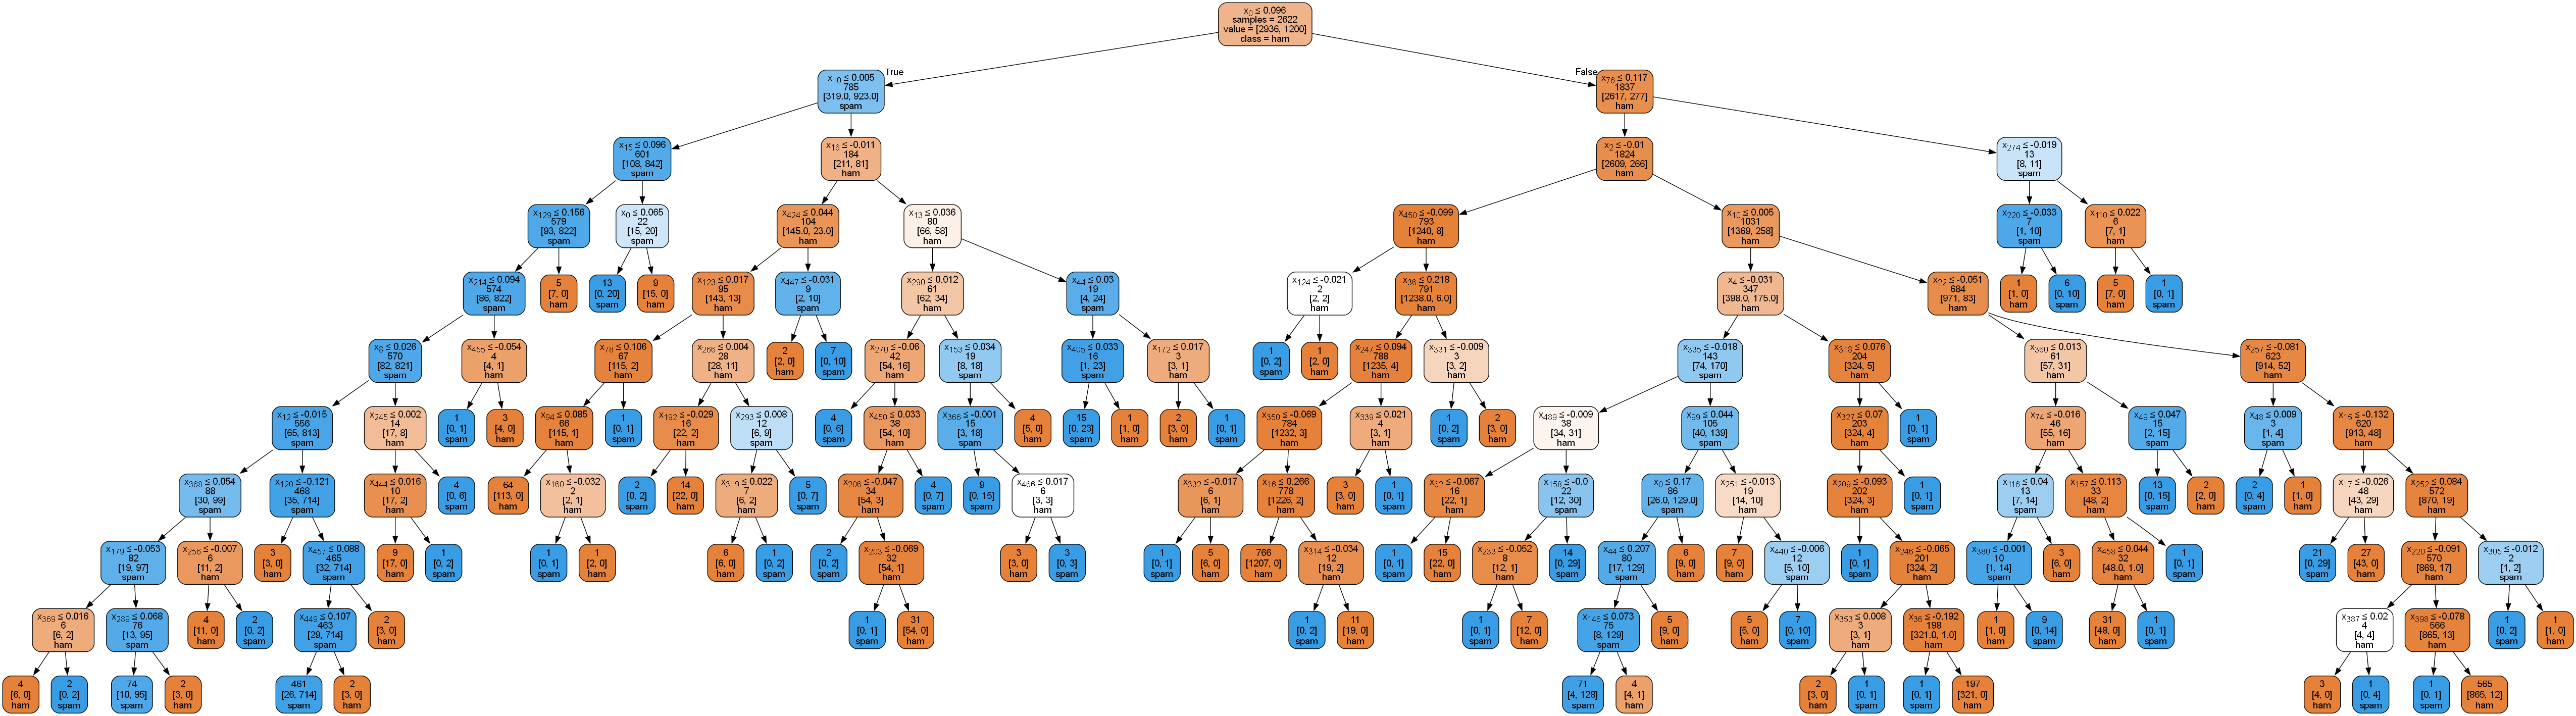

In [54]:
# 랜덤포레스트에서 가장 정확도가 높은 트리 찾기
# 랜덤포레스트는 기본적으로 100개의 트리를 생성합니다.
best_idx = 0
best_score = 0

for i, tree in enumerate(rf_model.estimators_):
    pred = tree.predict(X_test)
    score = accuracy_score(y_test, pred)
    if score > best_score:
        best_score = score
        best_idx = i

print(f"가장 좋은 트리 index: {best_idx}, 정확도: {best_score}")

# 해당 트리 시각화
plotDecisionTree(rf_model.estimators_[best_idx], class_names=['ham', 'spam'])

In [55]:
# Gradient Boosting 모델 생성 ()
gb_model = GradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['label'], test_size=0.2, random_state=42)

# 모델 학습
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

# 평가
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred))
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, y_pred))

Gradient Boosting Accuracy: 0.9497584541062802

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       742
           1       0.90      0.92      0.91       293

    accuracy                           0.95      1035
   macro avg       0.94      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



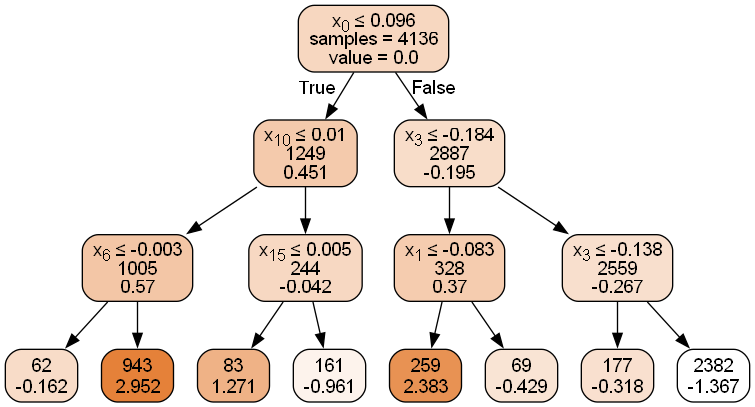

<Figure size 1200x800 with 0 Axes>

In [56]:
# Gradient Boosting의 첫 번째 트리 시각화
plt.figure(figsize=(12, 8))
plotDecisionTree(gb_model.estimators_[0, 0], class_names=['ham', 'spam'])

가장 좋은 트리 index: 0, 정확도: 0.927536231884058


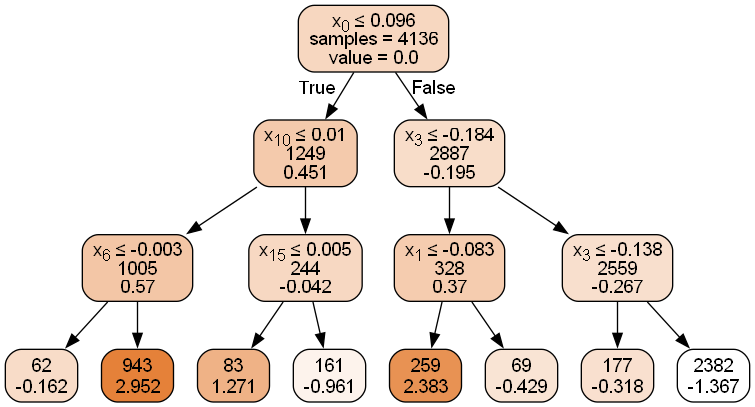

<Figure size 1200x800 with 0 Axes>

In [57]:
# Gradient Boosting에서 가장 정확도가 높은 트리 찾기
# Gradient Boosting은 기본적으로 100개의 트리를 생성합니다.
# 

best_idx = 0
best_score = 0

for i, tree in enumerate(gb_model.estimators_[:, 0]):
    # 개별 트리의 예측값은 실수(로짓)입니다. 0.5 기준으로 이진화
    pred = tree.predict(X_test)
    pred_binary = (pred > 0.5).astype(int)
    score = accuracy_score(y_test, pred_binary)
    if score > best_score:
        best_score = score
        best_idx = i

print(f"가장 좋은 트리 index: {best_idx}, 정확도: {best_score}")

# 해당 트리 시각화
plt.figure(figsize=(12, 8))
plotDecisionTree(gb_model.estimators_[best_idx, 0], class_names=['ham', 'spam'])

In [58]:
# SVD 
print(np.isnan(X_svd).any())
print(np.isinf(X_svd).any())
print(X_svd.shape)
print(type(X_svd))
print(df['label'].unique())  # [0 1] 또는 [1 0] 등 숫자여야 함
print(df['label'].dtype)  
print(np.isnan(X_train).any(), np.isinf(X_train).any())
print(np.isnan(y_train).any(), np.isinf(y_train).any())
print(X_train.shape, y_train.shape)

False
False
(5171, 500)
<class 'numpy.ndarray'>
[0 1]
int64
False False
False False
(4136, 500) (4136,)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)  # shape 확인

gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=42)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

(4136, 1000) (4136,)
Accuracy: 0.9642512077294686


In [60]:
# 데이터 분할 (이미 X_svd, df['label'] 준비됨)
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['label'], test_size=0.2, random_state=42)

# LightGBM 모델 생성 및 학습
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)
lgb_model.fit(X_train, y_train)

# 예측
y_pred = lgb_model.predict(X_test)

# 평가
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred))
print("\nLightGBM Classification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1206, number of negative: 2930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127497
[LightGBM] [Info] Number of data points in the train set: 4136, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291586 -> initscore=-0.887693
[LightGBM] [Info] Start training from score -0.887693
LightGBM Accuracy: 0.9690821256038648

LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       742
           1       0.94      0.96      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



c:\Users\Inkyu Yang\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


| 구분                | Random Forest (랜덤포레스트)                                   | Gradient Boosting (그래디언트 부스팅)                        |
|---------------------|---------------------------------------------------------------|-------------------------------------------------------------|
| 트리 생성 방식      | 여러 트리를 **병렬**로 독립적으로 생성                         | 여러 트리를 **순차적**으로, 이전 트리의 오차를 보정하며 생성   |
| 트리 간 영향        | 서로 **영향 없음**                                            | 이전 트리의 결과에 **영향 받음**                             |
| 데이터 샘플링       | 각 트리는 데이터의 일부(샘플+특성)로 학습 (배깅, 부트스트랩)     | 전체 데이터를 사용, 오차(잔차)에 집중                        |
| 예측 방식           | 트리들의 **투표(분류)/평균(회귀)** 결과                        | 트리들의 **예측값을 합산** (또는 가중합)                     |
| 과적합(Overfitting) | 비교적 강인함                                                 | 적절한 규제 없으면 과적합 위험 있음                          |
| 학습 속도           | **병렬 처리** 가능, 빠름                                       | **순차적** 처리, 느릴 수 있음                                |
| 대표 하이퍼파라미터 | n_estimators, max_depth, max_features 등                      | n_estimators, learning_rate, max_depth 등                    |
| 특징                | 트리들이 독립적, 앙상블 효과로 분산 감소                       | 트리들이 점진적으로 성능 개선, 오차를 반복적으로 보정         |
